In [1]:
import numpy as np
from matplotlib import pyplot as plt

from tensorflow import keras

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import os
import pandas as pd
import pickle

from feat_extractor import feature_extract
from architecture import RealNVP_sum

In [3]:
# for nicer plots
plt.style.use('default')

from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from matplotlib.cm import tab20, tab10
import corner

We do not provide the training files in order to avoid large files. However, we provide a pre-trained network and some test samples if you are just interested in understanding how the posterior is evaluated.

#### generating training samples, modifying geometry, training your own networks

If you are interested in generating your own samples and train your own networks, you can use the simulator we provide.
To generate 10k samples of 3 observed events with the priors used in our paper just use

```bash
    python3 generate_dataset.py --nsets 10000 --nobs 3
```

This is not very efficient and can take a long time: we recommend running this on several CPUs on a cluster.

If you want to modify the prior range, this can be done by modifying ```m_min, m_max, tau_min, tau_max``` in ```generate_dataset.py```. you can also use this to generate samples at fixed mass and lifetime.

If you want to modify the detector geometry, this can be done by modifying ```dump_x, dump_y, dump_z, z_min, z_max, z_cal, x_min, x_max, y_min, y_max, dr_gg, E_min``` in ```ALP_decay.py```

Once you have generated the training samples consisting of sets of n_obs events, define your own architecture/detector setup in the file ```yamls/set"yaml_counter".yaml```. yamls/set0.yaml is already present for one of the detector setups used in the paper, you can use this as reference. Then just run:
```bash
    python3 train_arch_cINN.py --nobs n_obs --counter yaml_counter
```
This will provide you with a folder ```modelscINN/modelcINN"n_obs"_"yaml_counter"/``` which contains: the weights of the trained network, the training curves, the scalers used to pre-process the samples, the hyperparameters defining the architecture and training.


## variable plots

We can start by visualizing the information contained in the files

In [4]:
colors = ['royalblue', 'salmon', 'yellowgreen']
custom_lines = [Line2D([0], [0], color=colors[icolor], lw=4) for icolor in range(3)]
sig_labs = [r"$m_a=0.2$GeV", r"$m_a=1$GeV", r"$m_a=4$GeV"]

We plot here only the ALP energy, starting from the low level observables, different high level observables can be constructed.

The feature extraction is automated with ```feat_extractor.py```, so you do not have to worry about the naming of the variables.

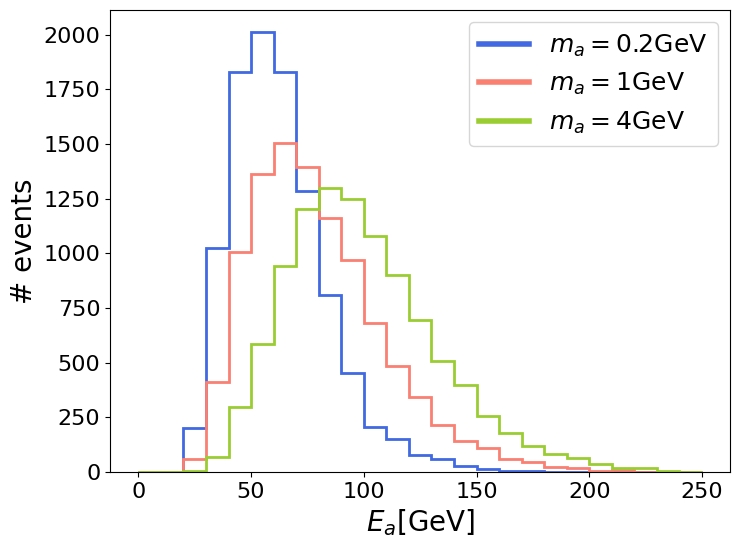

In [5]:
E_min = 1 # in GeV
uncertainties = {"sig ch": 0., "sig E (rel)": 0.00, "sig theta": 0.0, "sig phi": 0., "Eres": E_min} # everything perfect, minimum energy as for simulation

fig, axs = plt.subplots( figsize = (8, 6))
z_min, z_max, x_min, x_max, y_min, y_max = 10, 35, 1.25, 1.25, 1.25, 1.25 # geometry provided here
Ealp = []
calpha_alp = []
for mfixed in [0.2, 1, 4]:
    obsfile = "data/event_3_m_"+str(mfixed)+"_"+str(mfixed)+"_t_1_1.csv" # different parameter points
    feats_shad=feature_extract(obsfile, uncertainties["sig ch"], uncertainties["sig E (rel)"], uncertainties["sig theta"], uncertainties["sig phi"], Eres=uncertainties["Eres"], x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
    features_shad = feats_shad.extract_llo(0) # just look at the first of the three events
    Ealp.append(np.exp(features_shad[0])+np.exp(features_shad[1]))
Ealp = np.array(Ealp)
calpha_alp = np.array(calpha_alp)

for icolor in range(3):
    axs.hist(Ealp[icolor], bins=25, range= [0, 250], color=colors[icolor], histtype='step', linewidth=2)
axs.set_xlabel(r"$E_a$[GeV]", fontsize=20)
axs.set_ylabel(r"# events", fontsize=20)

axs.legend(custom_lines, sig_labs, fontsize = 18, loc='upper right')
axs.tick_params(axis='both', which='major', labelsize=16)
axs.tick_params(axis='both', which='minor', labelsize=8)

plt.show()

## Posterior for on axis detector

### single set posterior plot

With our pre-trained network, we can consider single sets of events and evaluate the posterior

In [6]:
ifolder = 0 # folder counter, by default only the one relative to 0 is present

# evaluate with previously trained neural network
# specify which trained models you want to use 
nobs = 3
folder_name = "modelscINN/modelcINN"+str(nobs)+"_"
modelfolder = folder_name +str(ifolder)
malp_min, malp_max = 0.1, 4.5
talp_min, talp_max = 0.1, 100
obsfile = "data/event_3_m_"+str(malp_min)+"_"+str(malp_max)+"_t_"+str(talp_min)+"_"+str(talp_max)+".csv" # different parameter points

We visualize the training curve. The training step with the lowest validation loss is used to save the weights (and visualized by the vertical line). 

{'Eres': 1.0, 'batch_size': 512, 'cinn_units': [128, 128, 128, 128], 'decayepo': 10, 'decayr': 0.9, 'learn_rate': 0.005, 'ncl': 4, 'sigs': [0.001, 0.01, 0.001, 0.001], 'sum_units': [64, 64, 64, 64], 'summary_dim': 2, 'file': '../data/Shadows/event_train_3_m_0.1_4.5_t_0.1_100_c_10_35_1.25_1.25_0.csv', 'n_epochs': 500}


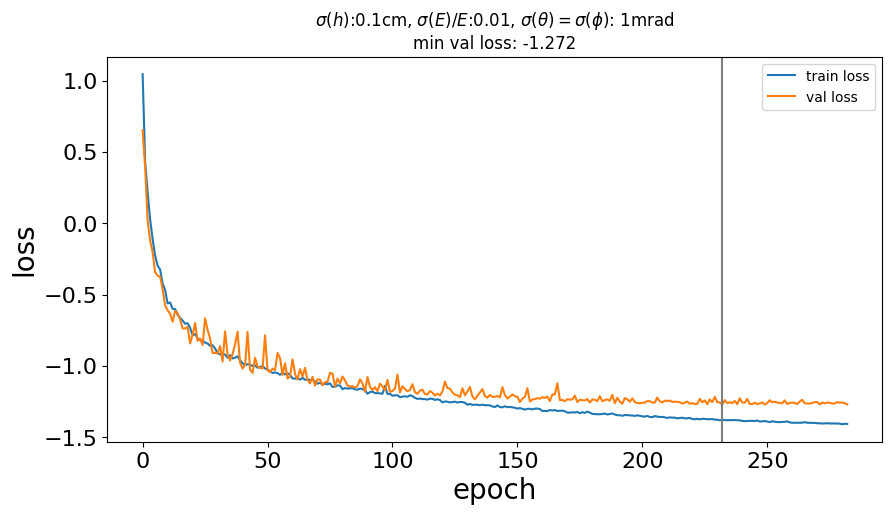

In [10]:
with open(modelfolder+'/meta_par.pkl', 'rb') as file_t:
    meta_par = pickle.load( file_t)
print(meta_par)

sigs = meta_par['sigs'] # the detector uncertainties are saved here

fig, axs = plt.subplots(figsize = (10,5))

with open(modelfolder+'/training.pkl', 'rb') as file_t:
    history = pickle.load(file_t)
    loss = history['loss']
    val_loss = history['val_loss']


axs.plot(loss, label='train loss')
axs.plot(val_loss, label='val loss')
axs.axvline(np.argmin(val_loss), color='grey')
# plt.yscale('log')
# plt.ylim(np.min(loss),2)
axs.set_title(r"$\sigma(h)$:"+str(100*sigs[0])+"cm, "+"$\sigma(E)/E$:"+str(sigs[1])+", "+"$\sigma(\\theta)=\sigma(\phi)$: "+str(int(1000*sigs[2]))+"mrad\nmin val loss: {:.3f}".format(np.min(val_loss)))
axs.set_xlabel("epoch", fontsize = 20)
axs.set_ylabel("loss", fontsize = 20)
axs.tick_params(axis='both', which='major', labelsize=16)
axs.tick_params(axis='both', which='minor', labelsize=8)
plt.legend()
plt.show()

Now we define the plotting range and import the file

In [11]:
plot_m_min, plot_m_max = np.log10(malp_min), np.log10(malp_max)
plot_tau_min, plot_tau_max = np.log10(talp_min/malp_max), np.log10(talp_max/malp_min)
m_plot, tau_plot = np.linspace(plot_m_min, plot_m_max, 100), np.linspace(plot_tau_min, plot_tau_max, 100)
MM, TT = np.meshgrid(m_plot, tau_plot)

plot_input = np.array([MM.flatten(), TT.flatten()]).T

feats=feature_extract(obsfile, sigs[0], sigs[1], sigs[2], sigs[3], Eres=1., x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)

malp, talp = feats.extract_model()
zobs = np.vstack((np.log10(malp), np.log10(talp/malp))).T # no need to scale this for now
np.random.seed(0) # just to have always the same smearing
features = np.vstack(([feats.extract_llo(iOBS) for iOBS in range(nobs)])) 

Here we load the weights (we perform a single training step just to initialize)

In [12]:
zscaler = pickle.load(open(modelfolder+'/zscaler.pkl', 'rb'))
zobs = np.vstack((np.log10(malp), np.log10(talp/malp))).T # no need to scale this  for now
plot_input = zscaler.transform(plot_input)


xscaler = pickle.load(open(modelfolder+'/xscaler.pkl', 'rb'))
xobs = features.T
xobs = xscaler.transform(xobs)

arch_par = {
    'n_coupling_layers': meta_par['ncl'],
    's_args': {
        'units': meta_par['cinn_units'],
        'activation': 'relu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': meta_par['cinn_units'],
        'activation': 'relu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2,
    'alpha': 1.,
    'use_permutation': False
    }
arch_par.update({"n_units_summary": meta_par['sum_units'],  "summary":  meta_par["summary_dim"]}) # summary can be different from input_dim


# this is just to build the model
NormFlowPost=RealNVP_sum(arch_par)
NormFlowPost.call([zobs, xobs])
NormFlowPost.compile(optimizer=keras.optimizers.Adam(learning_rate=meta_par['learn_rate']))

# fit for one epoch to initialize weights
# again, this is here just for compatibility reasons, if we save the whole model in tensorflow 2 we do not need this
NormFlowPost.fit(
        zobs, xobs, batch_size=meta_par['batch_size'], epochs=1,
        verbose=1, validation_split=0.2)
NormFlowPost.load_weights(modelfolder+"/weights.h5")

/home/alessandro/.local/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/alessandro/.local/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


16/16 [==============================] - 6s 86ms/step - loss: 2.0772 - val_loss: 1.8951


Next: show the posterior plot

In [13]:
iS = 125 # select one of the 10k events here

In [14]:
plot_m_min, plot_m_max = np.log10(malp_min), np.log10(malp_max)
plot_tau_min, plot_tau_max = np.log10(talp_min/malp_max), np.log10(talp_max/malp_min)

m_plot, tau_plot = np.linspace(plot_m_min, plot_m_max, 200), np.linspace(plot_tau_min, plot_tau_max, 200)
MM, TT = np.meshgrid(m_plot, tau_plot)
plot_input = np.array([MM.flatten(), TT.flatten()]).T
zscaler = pickle.load(open(modelfolder+'/zscaler.pkl', 'rb'))
plot_input = zscaler.transform(plot_input)

post_vals = NormFlowPost.log_like([plot_input, xobs[iS]*np.ones([len(plot_input), xobs.shape[1]])])
post_vals = np.array(post_vals).reshape(MM.shape[0], MM.shape[1])-np.log(np.prod(zscaler.scale_))
best_fit_sc  = plot_input[np.argmax(np.array(post_vals))]
best_fit = zscaler.inverse_transform(best_fit_sc)

znorm= np.array(NormFlowPost.distribution.sample(100000)) # we can use this to sample from underlying normal
zpost_sc = np.array(NormFlowPost.inverse(znorm, xobs[iS]*np.ones([len(znorm), xobs.shape[1]]))) # this trasnforms back
zpost = zscaler.inverse_transform(zpost_sc) # these are the posterior samples we want

/home/alessandro/.local/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


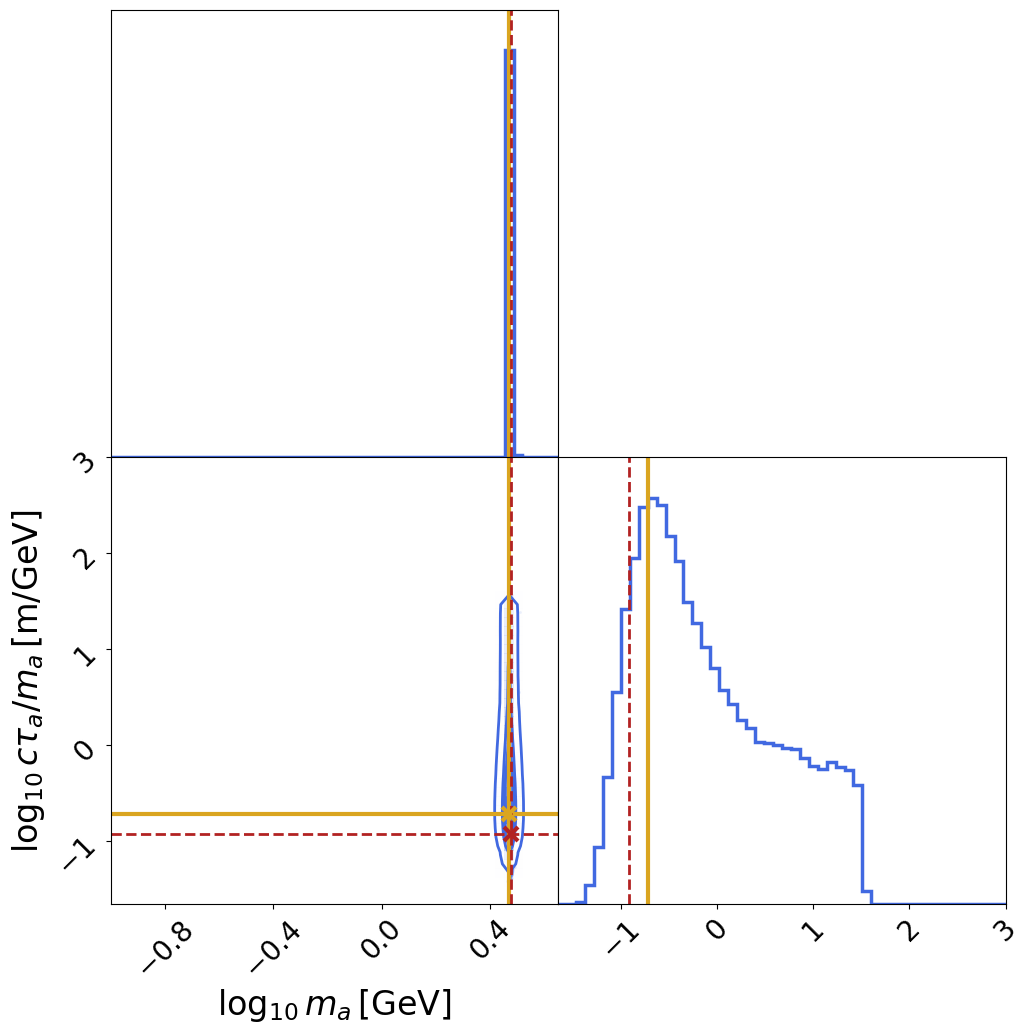

In [15]:
plevels = (0.5, 0.68,0.95,)
fig, axs = plt.subplots(2, 2, figsize=(12,12), gridspec_kw = {"wspace": 0, "hspace": 0})
figure = corner.corner(zpost, bins=50, smooth=0.5, color='royalblue', range = [[plot_m_min, plot_m_max],[plot_tau_min, plot_tau_max]], fig=fig, levels=plevels, hist_kwargs={"linewidth": 2.5}, contour_kwargs={"linewidths": 2})
axs = np.array(figure.axes).reshape((2, 2))

axs[0,0].axvline(best_fit[ 0], color='goldenrod', linewidth=3, linestyle='-')
axs[1,1].axvline(best_fit[1], color='goldenrod', linewidth=3, linestyle='-')
axs[0,0].axvline(zobs[iS, 0], color='firebrick', linewidth=2, linestyle='--')
axs[1,1].axvline(zobs[iS, 1], color='firebrick', linewidth=2, linestyle='--')
axs[1,0].axvline(best_fit[ 0], color='goldenrod', linewidth=3, linestyle='-')
axs[1,0].axhline(best_fit[1], color='goldenrod', linewidth=3, linestyle='-')
axs[1,0].axvline(zobs[iS, 0], color='firebrick', linewidth=2, linestyle='--')
axs[1,0].axhline(zobs[iS, 1], color='firebrick', linewidth=2, linestyle='--')
axs[1, 0].plot(zobs[iS, 0], zobs[iS, 1], marker='x', markersize=10, color='firebrick', markeredgewidth=3)
axs[1, 0].plot(best_fit[ 0], best_fit[ 1], marker='x', markersize=10, color='goldenrod', markeredgewidth=3)

axs[1, 0].set_xlabel(r'$\log_{10}\,m_a\,[\mathrm{GeV}]$', fontsize= 24)
axs[1, 0].set_ylabel(r'$\log_{10}\,c\tau_a/m_a\,[\mathrm{m/GeV}]$', fontsize= 24)

axs[0, 0].tick_params(axis='both', which='major', labelsize=20)
axs[0, 0].tick_params(axis='both', which='minor', labelsize=8)
axs[1, 0].tick_params(axis='both', which='major', labelsize=20)
axs[1, 0].tick_params(axis='both', which='minor', labelsize=8)
axs[1, 1].tick_params(axis='both', which='major', labelsize=20)
axs[1, 1].tick_params(axis='both', which='minor', labelsize=8)

axs[0,0].set_xlim(plot_m_min,plot_m_max)
axs[1,0].set_xlim(plot_m_min,plot_m_max)
axs[1,0].set_ylim(plot_tau_min, plot_tau_max)
axs[1,1].set_xlim(plot_tau_min, plot_tau_max)
plt.show()

For this single event we can evaluate the standard deviation in the marginal posteriors

In [16]:
np.std(zpost[:,0]), np.std(zpost[:,1])

(0.005269069, 0.7277413)

The estimators for the model parameter can be obtained by considering the 2D joint posterior.

In [17]:
best_fit

array([ 0.4704453 , -0.71789342])

But they can also be derived separately by maximing the marginal posterior. With this approach we do not have direct access to the marginal posteriors, but only to the samples from the marginal posteriors. So another way to get the parameter estimators is by taking the average of the marginal posterior samples. The average of the marginal posterior samples is nothing else than the estimator of the expected value under the marginal distributions. No large differences are expected for the mass estimator.

In [18]:
np.mean(zpost[:,0]), np.mean(zpost[:,1])

(0.47375008, -0.08667508)

### performance evaluation

If we want to evaluate the performance, we need to consider multiple sets (ideally 10k, but we will start with 25).

In [19]:
mfixed =1 # consider m_a=1 GeV
obsfile = "data/event_3_m_"+str(mfixed)+"_"+str(mfixed)+"_t_1_1"+".csv" # same parameter points

feats=feature_extract(obsfile, sigs[0], sigs[1], sigs[2], sigs[3], Eres=1., x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)

malp, talp = feats.extract_model()
features = np.vstack(([feats.extract_llo(iOBS) for iOBS in range(nobs)]))

zobs = np.vstack((np.log10(malp), np.log10(talp/malp))).T 
xobs = features.T
    
zscaler = pickle.load(open(modelfolder+'/zscaler.pkl', 'rb'))
zobs_sc = zscaler.transform(zobs)

xscaler = pickle.load(open(modelfolder+'/xscaler.pkl', 'rb'))
xobs = xscaler.transform(xobs)

/home/alessandro/.local/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/alessandro/.local/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [20]:
# this is for parallelization
from joblib import Parallel, delayed
import multiprocessing

num_cores = multiprocessing.cpu_count()

The scan is performed here. Also in this case for large N_obs it is better to launch on a cluster on several CPUs

In [21]:
N_obs = 25 # this takes a couple of minutes on a normal computer

# this can be vectorialized to evaluate faster, but it needs to store an array of dimension N_obs*N_norm*(10*n_obs+2)
perf_arr = []
def processInput(i_obs):
    zpost_sc = np.array(NormFlowPost.inverse(znorm, xobs[i_obs]*np.ones([len(znorm), xobs.shape[1]]))) # this trasnforms back
    zpost = zscaler.inverse_transform(zpost_sc)
    post_vals = NormFlowPost.log_like([zpost_sc, xobs[i_obs]*np.ones([len(zpost), xobs.shape[1]])])-np.log(np.prod(zscaler.scale_))
    best_fit  = zpost[np.argmax(np.array(post_vals))]
    # cov_m = np.cov(zpost.T) # we can also evalaute the covariance
    return [zobs[i_obs,0], zobs[i_obs,1], best_fit[0], best_fit[1], np.mean(zpost[:,0]), np.mean(zpost[:,1]), np.std(zpost[:,0]), np.std(zpost[:,1])]
perf_arr=Parallel(n_jobs=num_cores, backend='threading')(delayed(processInput)(i_obs) for i_obs in range(N_obs))
perf_arr=np.array(perf_arr)

We can visualize the inferred mass values here (both for the 2D best fit and the marginal expected values)

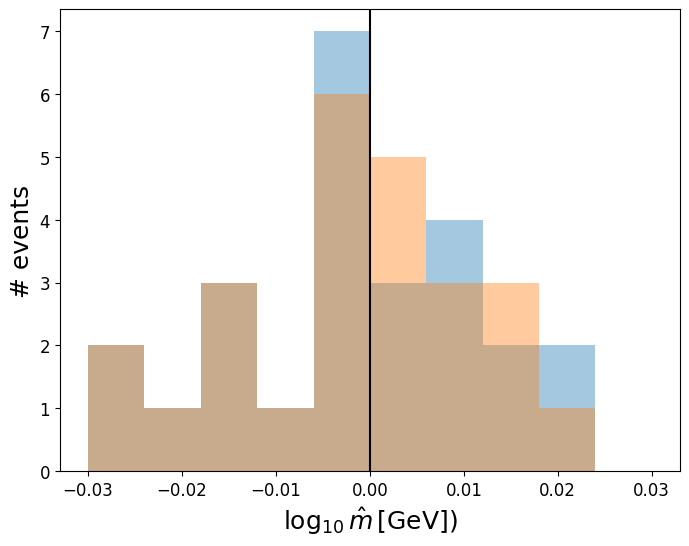

In [22]:
plt.figure(figsize=(8,6))
plt.hist(perf_arr[:,2], range=[-0.03,0.03], alpha=0.4)
plt.hist(perf_arr[:,4], range=[-0.03,0.03], alpha=0.4)
plt.axvline(np.log10(mfixed), color='black')
plt.xlabel(r"$\log_{10}\,\hat m\,[\mathrm{GeV}])$", fontsize=18)
plt.ylabel(r"# events", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=8)
plt.show()

The next plot corresponds to the blue plot in fig.12 (but with 25 points instead of 10k)

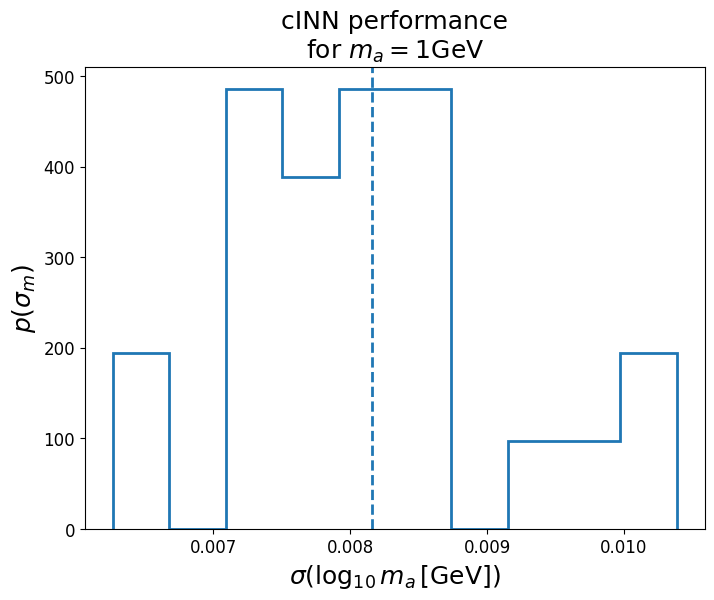

In [23]:
plt.figure(figsize=(8,6))
plt.hist(perf_arr[:,6], density=True,  histtype='step', linewidth=2)
plt.axvline(np.mean(perf_arr[:,6]), linewidth=2, linestyle = '--')

plt.title("cINN performance\nfor $m_a=$"+str(mfixed)+"GeV", fontsize=18)
plt.xlabel(r"$\sigma(\log_{10}\,m_a\,[\mathrm{GeV}])$", fontsize=18)
plt.ylabel(r"$p(\sigma_m)$", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=8)
plt.show()